# Support Vector Machines y Naive Bayes
Actividad Lección 7 || Programación Python para Machine Learning

Objetivos:
* Conocer los principios de las Máquinas de Vectores Soporte (SVM)
* Saber implementar en Python modelos de SVM para resolver problemas de clasificación y regresión

Datos del alumno:
* Víctor Luque Martín
* Máster Avanzado en Programación en Python para Hacking, BigData y Machine Learning

Fecha: 07/12/2022

# Tabla de Contenidos
1. [Importes](#importes)
2. [Carga del dataset](#carga)
3. [Conteo de Clases](#conteo)
    1. [Analisis de los datos](#analisis)
4. [Segmentación del conjunto de datos](#segmentacion)
5. [Normalización](#normalizacion)
6. [Modelos](#modelos)
    1. [Regresión Logística](#regresion)
    2. [K-Vecinos más cercanos](#knn)
7. [Evaluación de los modelos](#evaluacion)
8. [Optimizando KNN](#optimizando)

# Importes <a name="importes"></a>

In [129]:
import random, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, metrics
from sklearn.svm import SVC

# Carga del dataset <a class="anchor" name="carga"></a>
Se carga el dataset [Climate Model Simulation Crashes](https://archive.ics.uci.edu/ml/datasets/climate+model+simulation+crashes#) para trabajar la implementación de modelos SVM.

In [130]:
df = pd.read_csv('pop_failures.dat', sep='\s+')
df

,Study,Run,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,...,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome
0,1,1,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,...,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,0
1,1,2,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,...,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,1
2,1,3,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,...,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,1
3,1,4,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,...,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,1
4,1,5,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,...,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,3,176,0.657136,0.489375,0.133713,0.411950,0.087780,0.356289,0.480204,0.029678,...,0.280546,0.384117,0.885948,0.768482,0.459479,0.334482,0.573002,0.610183,0.737706,1
536,3,177,0.915894,0.842720,0.518947,0.090622,0.336981,0.893576,0.978703,0.674868,...,0.798108,0.353546,0.044796,0.990900,0.347027,0.512499,0.810549,0.593332,0.142565,0
537,3,178,0.478600,0.941185,0.769245,0.950776,0.189406,0.112743,0.745645,0.527096,...,0.193103,0.829563,0.101506,0.548878,0.381966,0.198811,0.867108,0.461632,0.652817,1
538,3,179,0.007793,0.779287,0.867468,0.704820,0.983282,0.420303,0.710612,0.174746,...,0.761134,0.436714,0.690132,0.825133,0.981656,0.113193,0.364799,0.201469,0.536535,1


# Conteo de Clases <a class="anchor" name="conteo"></a>


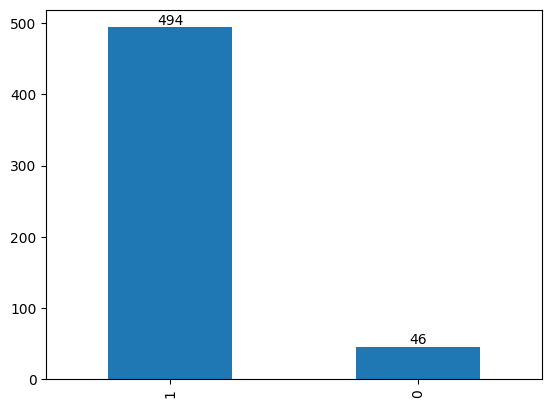

In [131]:
df['outcome'].value_counts().plot(kind='bar')
for i, v in enumerate(df['outcome'].value_counts()):
    plt.text(i, v, str(v), color='black', ha='center', va='bottom')
plt.show()

## Análisis de los datos <a class="anchor" name="analisis"></a>
* Como podemos observar, estamos ante un problema de clasificación binaria.
* Además, existe un desequilibrio de clases, siendo la clase 1 la que más se repite y la clase 0 la que menos. 
* Esto puede ser un problema para el modelo, ya que puede aprender a clasificar la clase 1 y no la clase 0.


# Segmentación del conjnto de datos <a class="anchor" name="segmentacion"></a>
* Las variables independientes son todas salvo "outcome", "Study" y "Run", según la descripción del dataset.
* La variable dependiente es "outcome", que indica si el modelo ha fallado o no.
* Se separa el conjunto de datos en dos conjuntos: uno de entrenamiento y otro de test.
* El conjunto de entrenamiento se utilizará para entrenar el modelo.
* El conjunto de test se utilizará para evaluar el rendimiento del modelo.

In [132]:
X = df.drop(columns=['outcome', "Study", "Run"])
y = df["outcome"]
seed = random.seed(time.time())
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=seed)

# Normalización de los datos <a class="anchor" name="normalizacion"></a>
* Los datos del dataset se encuentran escalados entre 0 y 1.
* Se utilizará StandardScaler para normalizar los datos.

In [133]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Máquinas de Vectores Soporte (SVM) <a class="anchor" name="svm"></a>
...

In [134]:
model = SVC(kernel='sigmoid', gamma=0.1, C=1.0, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluación del modelos <a class="anchor" name="evaluacion"></a>
Para evaluar el rendimiento de los modelos utilizaremos las siguientes métricas
* Precisión balanceada, ya que el conjunto de datos está desbalanceado y es la métrica que permite evaluar de manera más efectiva este tipo de casos.
* Matriz de confusión, para ver la distribución de los aciertos y errores.

In [135]:
# Balanced accuracy, Accuracy, Precision, Recall, F1 as df
df_metrics = pd.DataFrame(columns=['Precisión Balanceada'], index=['SVM'], data=[metrics.balanced_accuracy_score(y_test, y_pred)])
df_metrics

,Precisión Balanceada
SVM,0.761


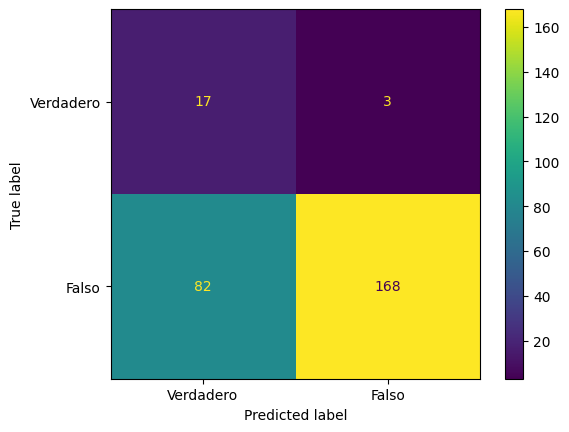

In [136]:
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=['Verdadero', 'Falso']).plot()
plt.show()

# Optimizando SVM <a class="anchor" name="optimizando"></a>
Teniendo en cuenta la métrica de precisión balanceada, se emplarán diferentes valores de k para ver cuál es el que mejor rendimiento tiene.

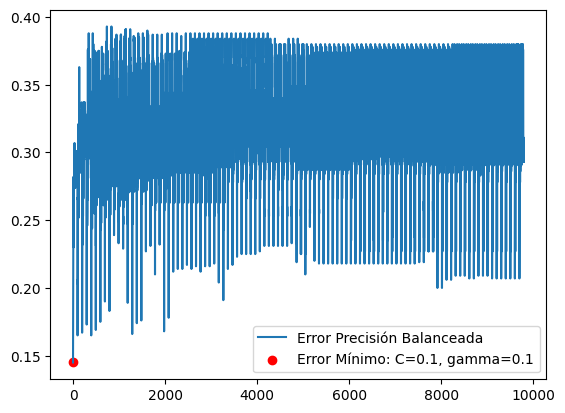

In [138]:
results = pd.DataFrame(columns=['C', 'gamma', 'Precisión Balanceada'])
rango = np.arange(.01, 100, .01)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    for C in rango:
        for gamma in rango:
            model = SVC(C=C, kernel=kernel, gamma=gamma, class_weight='balanced')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            results.loc[len(results)] = [C, gamma, 1-metrics.balanced_accuracy_score(y_test, y_pred)]